In [1]:
import numpy as np
import pandas as pd 
from keras.preprocessing.image import ImageDataGenerator, load_img
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import random
import os

FAST_RUN = False
IMAGE_WIDTH=128
IMAGE_HEIGHT=128
IMAGE_SIZE=(IMAGE_WIDTH, IMAGE_HEIGHT)
IMAGE_CHANNELS=3

Using TensorFlow backend.


Load data

In [2]:
filenames = os.listdir("./final-exam-data/data/kaggle_dogcat/train")
categories = []
for filename in filenames:
    category = filename.split('.')[0]
    if category == 'dog':
        categories.append(0)
    else:
        categories.append(1)

df = pd.DataFrame({
    'filename': filenames,
    'category': categories
})


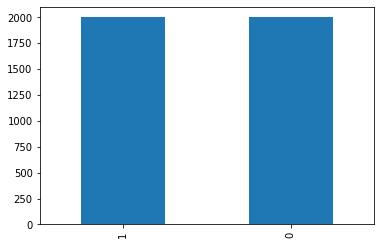

In [3]:
df['category'].value_counts().plot.bar()

In [4]:
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, Activation, BatchNormalization

model = Sequential()

model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT, IMAGE_CHANNELS)))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(128, (3, 3), activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.5))
model.add(Dense(2, activation='softmax')) # 2 because we have cat and dog classes

model.compile(loss='categorical_crossentropy', optimizer='rmsprop', metrics=['accuracy'])

model.summary()

W0815 21:33:16.874582 20216 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0815 21:33:16.900099 20216 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0815 21:33:16.904108 20216 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.

W0815 21:33:16.935121 20216 deprecation_wrapper.py:119] From C:\Users\Julian\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:174: The name tf.get_default_session is deprecated. Please use tf.compat.v1.get_default_session instead.

W0815 21:33:16.937101 20216 deprecation_wrapper.py:1

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_1 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
batch_normalization_1 (Batch (None, 126, 126, 32)      128       
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 63, 63, 32)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 63, 63, 32)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
batch_normalization_2 (Batch (None, 61, 61, 64)        256       
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 30, 30, 64)        0         
__________

In [5]:
from keras.callbacks import EarlyStopping, ReduceLROnPlateau
earlystop = EarlyStopping(patience=10)
learning_rate_reduction = ReduceLROnPlateau(monitor='val_acc', 
                                            patience=2, 
                                            verbose=1, 
                                            factor=0.5, 
                                            min_lr=0.00001)
callbacks = [earlystop, learning_rate_reduction]

In [6]:
df["category"] = df["category"].replace({1: 'cat', 0: 'dog'}) 

In [7]:
train_df, validate_df = train_test_split(df, test_size=0.20, random_state=42)
train_df = train_df.reset_index(drop=True)
validate_df = validate_df.reset_index(drop=True)

In [8]:
total_train = train_df.shape[0]
total_validate = validate_df.shape[0]
batch_size=15

In [9]:
train_datagen = ImageDataGenerator(
    rotation_range=15,
    rescale=1./255,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

train_generator = train_datagen.flow_from_dataframe(
    train_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 3200 validated image filenames belonging to 2 classes.


In [10]:
validation_datagen = ImageDataGenerator(rescale=1./255)
validation_generator = validation_datagen.flow_from_dataframe(
    validate_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical',
    batch_size=batch_size
)

Found 800 validated image filenames belonging to 2 classes.


In [11]:
example_df = train_df.sample(n=1).reset_index(drop=True)
example_generator = train_datagen.flow_from_dataframe(
    example_df, 
    "./final-exam-data/data/kaggle_dogcat/train", 
    x_col='filename',
    y_col='category',
    target_size=IMAGE_SIZE,
    class_mode='categorical'
)

Found 1 validated image filenames belonging to 1 classes.


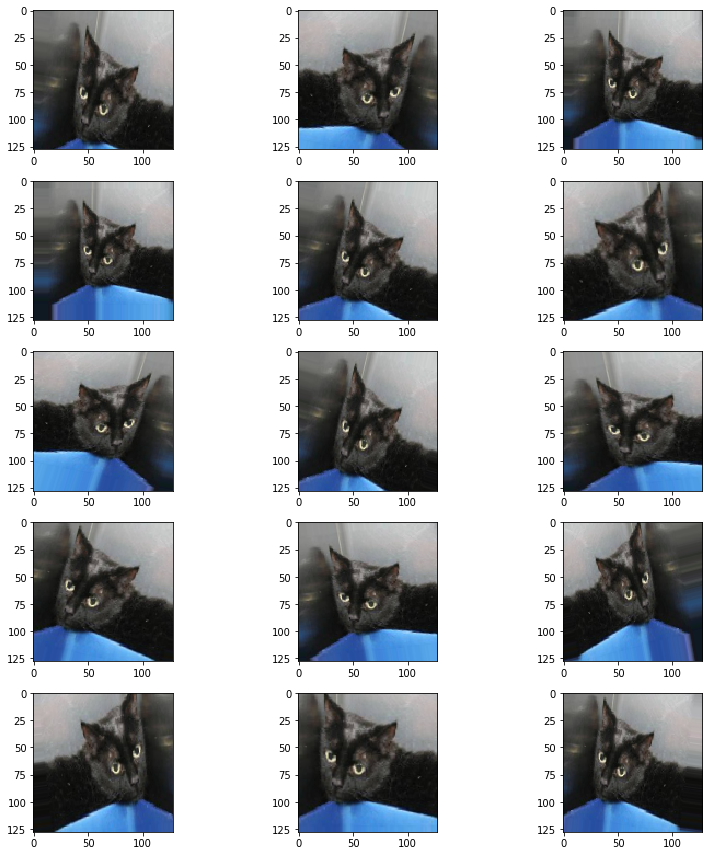

In [12]:
plt.figure(figsize=(12, 12))
for i in range(0, 15):
    plt.subplot(5, 3, i+1)
    for X_batch, Y_batch in example_generator:
        image = X_batch[0]
        plt.imshow(image)
        break
plt.tight_layout()
plt.show()

In [13]:
epochs=3 if FAST_RUN else 50
history = model.fit_generator(
    train_generator, 
    epochs=epochs,
    validation_data=validation_generator,
    validation_steps=total_validate//batch_size,
    steps_per_epoch=total_train//batch_size,
    callbacks=callbacks
)

W0815 21:33:22.104126 20216 deprecation.py:323] From C:\Users\Julian\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Epoch 1/50
213/213 [==============================] - 24s 112ms/step - loss: 1.1193 - acc: 0.5587 - val_loss: 1.4781 - val_acc: 0.5283
Epoch 2/50
213/213 [==============================] - 18s 87ms/step - loss: 0.7854 - acc: 0.5931 - val_loss: 0.8749 - val_acc: 0.6382
Epoch 3/50
213/213 [==============================] - 20s 93ms/step - loss: 0.7097 - acc: 0.6106 - val_loss: 0.7857 - val_acc: 0.6191
Epoch 4/50
213/213 [==============================] - 18s 85ms/step - loss: 0.6426 - acc: 0.6504 - val_loss: 0.8049 - val_acc: 0.5299

Epoch 00004: ReduceLROnPlateau reducing learning rate to 0.0005000000237487257.
Epoch 5/50
213/213 [==============================] - 19s 88ms/step - loss: 0.5830 - acc: 0.6917 - val_loss: 0.5393 - val_acc: 0.7312
Epoch 6/50
213/213 [==============================] - 18s 83ms/step - loss: 0.5673 - acc: 0.7064 - val_loss: 0.5194 - val_acc: 0.7439
Epoch 7/50
213/213 [==============================] - 19s 87ms/step - loss: 0.5490 - acc: 0.7243 - val_loss: 0.545

In [14]:
model.save_weights("model.h5")

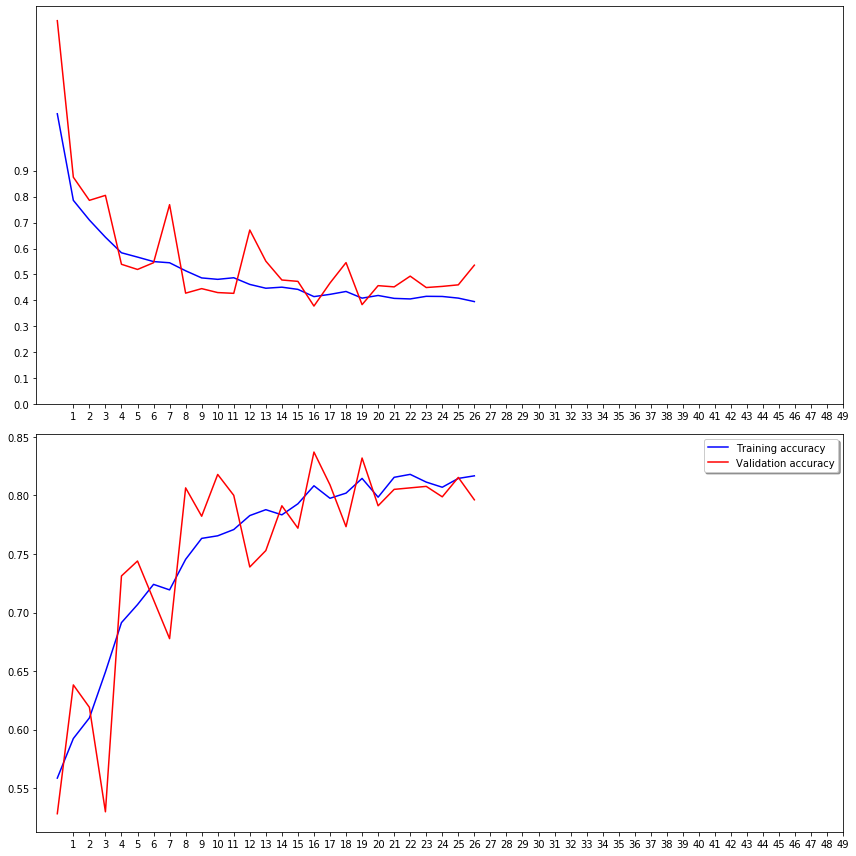

In [15]:
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 12))
ax1.plot(history.history['loss'], color='b', label="Training loss")
ax1.plot(history.history['val_loss'], color='r', label="validation loss")
ax1.set_xticks(np.arange(1, epochs, 1))
ax1.set_yticks(np.arange(0, 1, 0.1))

ax2.plot(history.history['acc'], color='b', label="Training accuracy")
ax2.plot(history.history['val_acc'], color='r',label="Validation accuracy")
ax2.set_xticks(np.arange(1, epochs, 1))

legend = plt.legend(loc='best', shadow=True)
plt.tight_layout()
plt.show()

Prepare Testing data

In [40]:
test_filenames = os.listdir("./final-exam-data/data/kaggle_dogcat/test")
test_df = pd.DataFrame({
    'filename': test_filenames
})
nb_samples = test_df.shape[0]

In [41]:
test_gen = ImageDataGenerator(rescale=1./255)
test_generator = test_gen.flow_from_dataframe(
    test_df, 
    "./final-exam-data/data/kaggle_dogcat/test", 
    x_col='filename',
    y_col=None,
    class_mode=None,
    target_size=IMAGE_SIZE,
    batch_size=batch_size,
    shuffle=False
)

Found 400 validated image filenames.


Predict

In [42]:
predict = model.predict_generator(test_generator, steps=np.ceil(nb_samples/batch_size))
predict

array([[3.48761350e-01, 6.51238680e-01],
       [9.30483282e-01, 6.95166886e-02],
       [9.81230617e-01, 1.87694430e-02],
       [3.16888429e-02, 9.68311131e-01],
       [9.97581124e-01, 2.41886266e-03],
       [2.61953503e-01, 7.38046467e-01],
       [7.68136740e-01, 2.31863290e-01],
       [6.24974906e-01, 3.75025064e-01],
       [9.99107897e-01, 8.92094336e-04],
       [9.65758026e-01, 3.42419744e-02],
       [1.50661096e-01, 8.49338949e-01],
       [9.98682320e-01, 1.31770573e-03],
       [1.92850694e-01, 8.07149291e-01],
       [9.99771178e-01, 2.28841804e-04],
       [9.15540099e-01, 8.44598934e-02],
       [3.54718328e-01, 6.45281672e-01],
       [3.03633953e-03, 9.96963680e-01],
       [9.99738395e-01, 2.61595036e-04],
       [3.87867332e-01, 6.12132728e-01],
       [9.98961806e-01, 1.03815773e-03],
       [9.81257439e-01, 1.87425949e-02],
       [9.13745463e-01, 8.62545446e-02],
       [5.53890407e-01, 4.46109563e-01],
       [1.00000000e+00, 4.29551186e-08],
       [9.991146

In [43]:
test_df['category'] = np.argmax(predict, axis=-1)
test_df['category']=predict[:,0]
test_df['category']

0      0.348761
1      0.930483
2      0.981231
3      0.031689
4      0.997581
5      0.261954
6      0.768137
7      0.624975
8      0.999108
9      0.965758
10     0.150661
11     0.998682
12     0.192851
13     0.999771
14     0.915540
15     0.354718
16     0.003036
17     0.999738
18     0.387867
19     0.998962
20     0.981257
21     0.913745
22     0.553890
23     1.000000
24     0.999115
25     0.687065
26     0.475386
27     0.450703
28     0.662703
29     0.104288
         ...   
370    0.817912
371    0.996113
372    0.826472
373    0.945047
374    0.999178
375    0.021428
376    0.509027
377    0.835851
378    0.529073
379    0.960670
380    0.625845
381    0.276358
382    0.485916
383    0.996514
384    0.998844
385    0.052460
386    0.030462
387    0.033520
388    0.031256
389    0.509439
390    0.790089
391    0.118911
392    0.591796
393    0.945041
394    0.028110
395    0.257704
396    0.983635
397    0.996331
398    0.997054
399    0.993172
Name: category, Length: 

In [44]:
label_map = dict((v,k) for k,v in train_generator.class_indices.items())
test_df['category'] = test_df['category'].replace(label_map)

In [45]:
test_df['category'] = test_df['category'].replace({ 'dog': 0, 'cat': 1 })

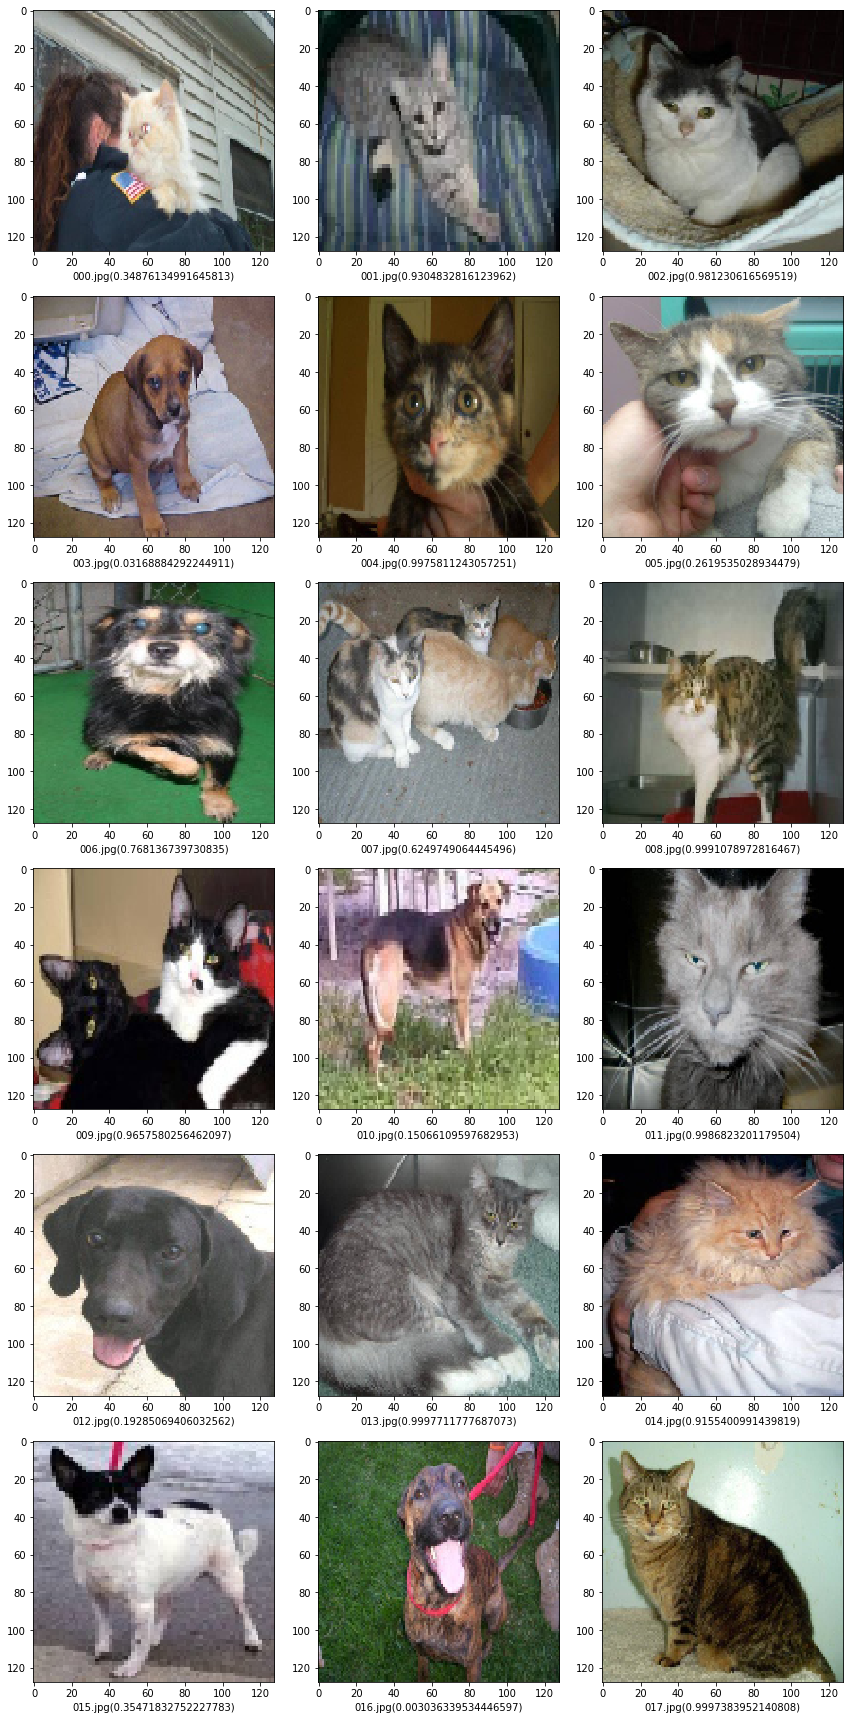

In [46]:
sample_test = test_df.head(18)
sample_test.head()
plt.figure(figsize=(12, 24))
for index, row in sample_test.iterrows():
    filename = row['filename']
    category = row['category']
    img = load_img("./final-exam-data/data/kaggle_dogcat/test/"+filename, target_size=IMAGE_SIZE)
    plt.subplot(6, 3, index+1)
    plt.imshow(img)
    plt.xlabel(filename + '(' + "{}".format(category) + ')' )
plt.tight_layout()
plt.show()

In [47]:
submission_df = test_df.copy()
submission_df['ID'] = submission_df['filename'].str.split('.').str[0]
submission_df['Predicted'] = submission_df['category']
submission_df.drop(['filename', 'category'], axis=1, inplace=True)
submission_df.to_csv('submission.csv', index=False)